In [1]:
import jax, jax.numpy as jnp
import matplotlib.pyplot as plt

from utils import r2_score, minmax_scaler


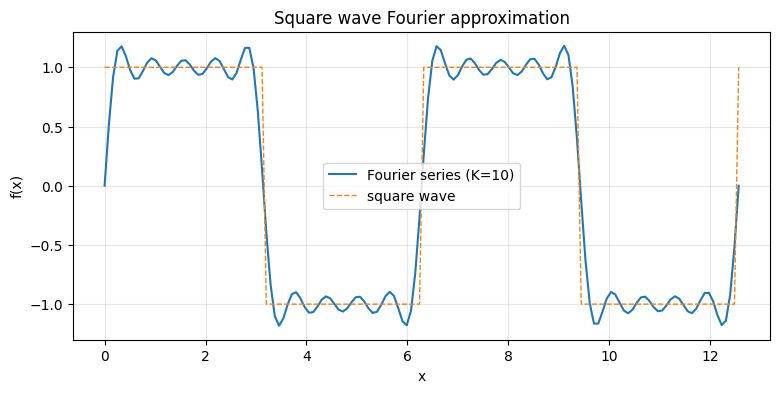

In [2]:
def target_function(x):
    res = c0
    for idx, c in enumerate(coeffs):
        exponent = (idx + 1) * x * 1j
        conj_c = jnp.conjugate(c)
        res += c * jnp.exp(exponent) + conj_c * jnp.exp(-exponent)
    return jnp.real(res)


def square_wave(x):
    return jnp.where(jnp.sin(x) >= 0.0, 1.0, -1.0)

def square_wave_coeffs(K):
    n = jnp.arange(1, K+1)
    coeffs = jnp.where(n % 2 == 1, -2j / (jnp.pi * n), 0.0 + 0.0j)
    c0 = 0
    return c0, coeffs


def sawtooth(x, amplitude=1.0):
    xr = ((x + jnp.pi) % (2*jnp.pi)) - jnp.pi
    return amplitude * (xr / jnp.pi)

def coeffs_sawtooth(K, amplitude=1.0, period=2*jnp.pi, phase=0.0):
    # base is ±1 amplitude; scale with 'amplitude'
    # scaling = 2*jnp.pi / period
    n = jnp.arange(1, K+1)
    coeffs = 1j * (-1.0)**n / (jnp.pi * n)
    # phase shift x -> x - phase
    # coeffs = amplitude * base * jnp.exp(-1j * n * scaling * phase)
    c0 = 0.0
    return c0, coeffs

def coeffs_triangle_even(K, amplitude=1.0, period=2*jnp.pi, phase=0.0):
    scaling = 2*jnp.pi / period
    n = jnp.arange(1, K+1)
    base = jnp.where(n % 2 == 1, 4.0/(jnp.pi**2 * n**2), 0.0)
    # even wave -> cosine-only; phase shift multiplies by e^{-i n phase}
    coeffs = amplitude * base * jnp.exp(-1j * n * scaling * phase)
    c0 = 0.0
    return c0, coeffs.astype(jnp.complex64), scaling

def coeffs_abs_sin(K, amplitude=1.0, period=2*jnp.pi, phase=0.0):
    scaling = 2*jnp.pi / period
    n = jnp.arange(1, K+1)
    is_even = (n % 2 == 0)
    m = n // 2
    base = jnp.where(is_even, -2.0/(jnp.pi*(4.0*m**2 - 1.0)), 0.0)
    coeffs = amplitude * base * jnp.exp(-1j * n * scaling * phase)
    c0 = amplitude * (2.0/jnp.pi)
    return c0, coeffs.astype(jnp.complex64), scaling

def coeffs_rect_duty(K, A=1.0, duty=0.5, phase=0.0, period=2*jnp.pi):
    scaling = 2*jnp.pi / period
    n = jnp.arange(1, K+1)
    base = (A * jnp.sin(jnp.pi * n * duty) / (jnp.pi * n))
    coeffs = base * jnp.exp(-1j * n * phase * scaling)
    c0 = A * (2.0 * duty - 1.0)
    return c0, coeffs.astype(jnp.complex64), scaling

def coeffs_v_wave(K, amplitude=1.0, period=2*jnp.pi, phase=0.0):
    scaling = 2*jnp.pi / period
    n = jnp.arange(1, K+1)
    base = jnp.where(n % 2 == 1, -2.0/(jnp.pi**2 * n**2), 0.0)
    coeffs = amplitude * base * jnp.exp(-1j * n * scaling * phase)
    c0 = amplitude * 0.5
    return c0, coeffs.astype(jnp.complex64), scaling


c0, coeffs = square_wave_coeffs(10)


x = jnp.linspace(0, 4*jnp.pi, 150)

y_hat = target_function(x)

# x = minmax_scaler(x) * 2 * jnp.pi
# y_hat = minmax_scaler(y_hat) * 2 - 1

y_true = square_wave(x)

plt.figure(figsize=(9, 4))
plt.plot(x, y_hat, label=f"Fourier series (K={10})")
plt.plot(x, y_true, linestyle="--", linewidth=1.0, label="square wave")
plt.title("Square wave Fourier approximation")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

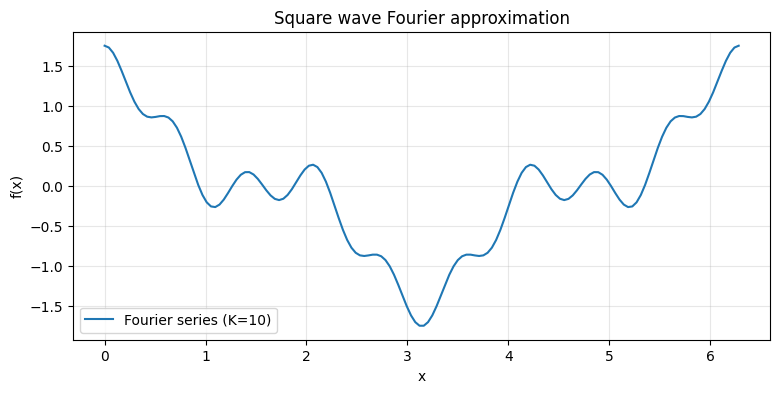

In [3]:
def scaling_from_period(period=2*jnp.pi):
    return 2*jnp.pi / period


def weierstrass(x, a=0.5, b=3, M=12):
    m = jnp.arange(M, dtype=jnp.float32)
    return jnp.sum((a**m) * jnp.cos((b**m) * x[..., None]), axis=-1)

def coeffs_weierstrass(K, a=0.5, b=3, phase=0.0):
    scaling = 1.0
    coeffs = jnp.zeros(K, dtype=jnp.complex64)
    n = 1
    m = 0
    while n <= K:
        coeffs = coeffs.at[n-1].set( (a**m)/2 * jnp.exp(-1j * n * phase) )
        n *= b; m += 1
    c0 = 0.0
    return c0, coeffs, scaling


def riemann(x, K=3):
    k = jnp.arange(1, K+1, dtype=jnp.float32)
    return jnp.sum(jnp.sin((k*k) * x[..., None]) / (k*k), axis=-1)

def coeffs_riemann(K, period=2*jnp.pi, phase=0.0):

    scaling = scaling_from_period(period)
    coeffs = jnp.zeros(K, dtype=jnp.complex64)
    k = 1
    while k*k <= K:
        n = k*k
        coeffs = coeffs.at[n-1].set( (-1j)/(2.0*k*k) * jnp.exp(-1j * n * scaling * phase) )
        k += 1
    c0 = 0.0
    return c0, coeffs, scaling


def log_sine_cusp(x, scale=1.0, eps=1e-12):
    return -scale * jnp.log(2.0 * jnp.maximum(jnp.abs(jnp.sin(x/2)), eps))

def coeffs_log_sine(K, scale=1.0, period=2*jnp.pi, phase=0.0):

    scaling = scaling_from_period(period)
    n = jnp.arange(1, K+1, dtype=jnp.float32)
    coeffs = (scale * 0.5 / n) * jnp.exp(-1j * n * scaling * phase)
    c0 = 0.0
    return c0, coeffs.astype(jnp.complex64), scaling


def lacunary(x, rho=0.8, beta=3, phases=None, M=3):
    m = jnp.arange(M, dtype=jnp.float32)
    if phases is None:
        phi = jnp.zeros(M, dtype=jnp.float32)
    else:
        phi = jnp.asarray(phases, dtype=jnp.float32)
        phi = jnp.pad(phi, (0, max(0, M - phi.shape[0])))[:M]
    return jnp.sum((rho**m) * jnp.cos((beta**m) * x[..., None] + phi), axis=-1)

def coeffs_lacunary(K, rho=0.8, beta=3, phases=None, period=2*jnp.pi, phase=0.0):

    scaling = scaling_from_period(period)
    coeffs = jnp.zeros(K, dtype=jnp.complex64)

    phi_list = []
    m = 0
    n = 1
    while n <= K:
        if phases is None:
            phi_list.append(0.0)
        else:
            # pull phase from list if available, else 0
            phi_list.append(float(phases[m]) if m < len(phases) else 0.0)
        n *= beta
        m += 1

    # fill coeffs
    n = 1
    m = 0
    while n <= K:
        c_nm = (rho**m)/2.0 * jnp.exp(1j * phi_list[m]) * jnp.exp(-1j * n * scaling * phase)
        coeffs = coeffs.at[n-1].set(c_nm.astype(jnp.complex64))
        n *= beta
        m += 1

    c0 = 0.0
    return c0, coeffs, scaling


c0, coeffs, scaling = coeffs_weierstrass(10)


x = jnp.linspace(0, 2*jnp.pi, 150)

y_hat = target_function(x)

# x = minmax_scaler(x) * 2 * jnp.pi
# y_hat = minmax_scaler(y_hat) * 2 - 1

y_true = weierstrass(x)

plt.figure(figsize=(9, 4))
plt.plot(x, y_hat, label=f"Fourier series (K={10})")
#plt.plot(x, y_true, linestyle="--", linewidth=1.0, label="non-diff function")
plt.title("Square wave Fourier approximation")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\test\AppData\Local\Temp\ipykernel_17412\683544056.py:24: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in arange is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  n = jnp.arange(1, K+1, dtype=jnp.float64)[:, None]  # (K,1)


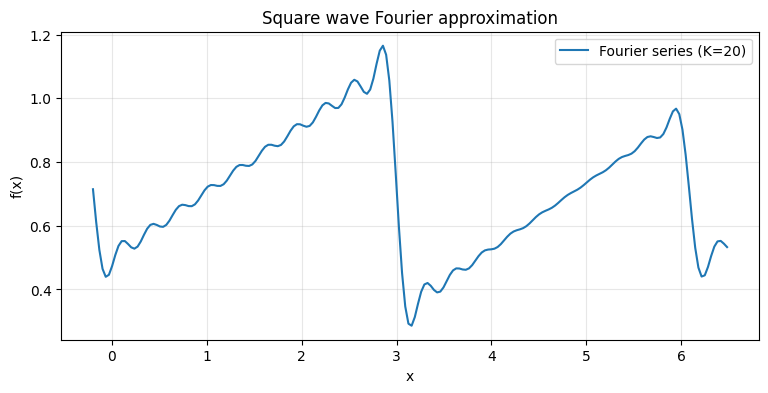

In [4]:
def coeffs_nrz_steps(t_edges, v_levels, K, period=2*jnp.pi, phase=0.0):

    t = jnp.asarray(t_edges)
    v = jnp.asarray(v_levels)
    assert t.shape[0] == v.shape[0] + 1, "need M+1 edges and M levels"
    # assert float(t[0]) == -jnp.pi and float(t[-1]) == jnp.pi

    scaling = scaling_from_period(period)


    widths = t[1:] - t[:-1]
    c0 = jnp.sum(v * widths) / (2.0 * jnp.pi)

    jumps = v[1:] - v[:-1]
    tj = t[1:-1]

    n = jnp.arange(1, K+1, dtype=jnp.float64)[:, None]  # (K,1)
    cn = (jnp.sum(jumps[None, :] * jnp.exp(-1j * n * tj[None, :]), axis=1)
          / (2.0 * jnp.pi * 1j * n[:, 0]))
    coeffs = cn * jnp.exp(-1j * (jnp.arange(1, K+1) * scaling * phase))
    return float(c0), coeffs.astype(jnp.complex64), scaling


K = 20
t_edges = jnp.array([-jnp.pi, -0.2, 3, jnp.pi])
v_levels = jnp.array([+1, +0.5, -0.3])
c0, coeffs, scaling = coeffs_nrz_steps(t_edges, v_levels, K)

x = jnp.linspace(-0.2, 2*jnp.pi+0.2, 200)

y_hat = target_function(x)

# x = minmax_scaler(x) * 2 * jnp.pi
# y_hat = minmax_scaler(y_hat) * 2 - 1

# y_true = lacunary(x)

plt.figure(figsize=(9, 4))
plt.plot(x, y_hat, label=f"Fourier series (K={K})")
# plt.plot(x, y_true, linestyle="--", linewidth=1.0, label="non-diff function")
plt.title("Square wave Fourier approximation")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
dpi = 500
image_save_dpi = 1200

import matplotlib_inline

%matplotlib inline
%matplotlib inline

import matplotlib.pyplot as plt

matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
%config InlineBackend.figure_formats = ['svg']

import seaborn as sns
import matplotlib

sns.set(rc={"figure.dpi":dpi, 'savefig.dpi':dpi})
sns.set_context('notebook')
sns.set_style("ticks")
matplotlib.rcParams["figure.dpi"] = dpi
plt.rcParams['figure.dpi'] = dpi

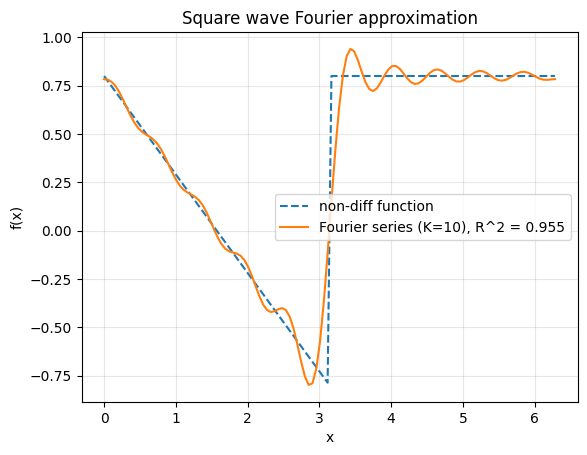

In [6]:
def saw_square(x):
    x = (x % (2*jnp.pi) + 2*jnp.pi) % (2*jnp.pi)    # map to [0, 2π)
    return jnp.where(x < jnp.pi, 1.0 - 2.0*x/jnp.pi, 1.0)

def coeffs_saw_square(K):
    n = jnp.arange(1, K+1, dtype=jnp.float32)
    parity = (-1.0) ** n  # = +1 (even n), = -1 (odd n)
    coeffs = -1j * parity / (jnp.pi * n) + (1.0 - parity) / (jnp.pi**2 * n**2)
    c0 = 0.5
    return c0, coeffs


c0, coeffs = coeffs_saw_square(10)


x = jnp.linspace(0, 2*jnp.pi, 120)

y_hat = target_function(x) * 0.8

# x = minmax_scaler(x) * 2 * jnp.pi
# y_hat = minmax_scaler(y_hat) * 2 - 1

y_true = saw_square(x) * 0.8
# y_true = minmax_scaler(y_true) * 2 - 1

r2 = r2_score(y_true, y_hat)

# plt.figure(figsize=(10, 5))
plt.plot(x, y_true, linestyle="--", linewidth=1.5, label="non-diff function")
plt.plot(x, y_hat, label=f"Fourier series (K={10}), R^2 = {r2:.3f}")
plt.title("Square wave Fourier approximation")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

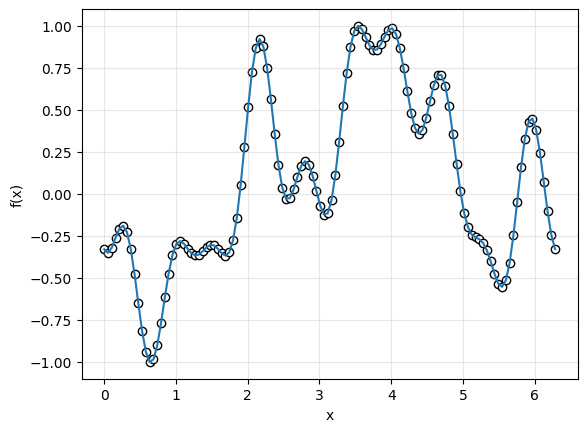

Array([-0.37241954+0.23431538j, -0.00768933-0.02899783j,
        0.2424051 +0.09402002j, -0.00968506-0.00708517j,
        0.09149331+0.1890211j ,  0.00709596-0.00369423j,
       -0.06186681-0.07209367j, -0.06571778+0.02410754j,
        0.00288075+0.0052632j , -0.15736917-0.0288954j ], dtype=complex64)

In [7]:
def coeffs_degree10_diverse():

    # n = 1...10
    mags   = jnp.array([0.44, 0.030, 0.26, 0.012, 0.21, 0.008, 0.095, 0.070, 0.006, 0.16], dtype=jnp.float32)
    phases = jnp.array([ 2.58,-1.83, 0.37,-2.51, 1.12,-0.48,-2.28, 2.79, 1.07,-2.96], dtype=jnp.float32)
    coeffs = (mags * jnp.exp(1j * phases)).astype(jnp.complex64)
    return coeffs


def target_function(x, coeffs, c0=0.0):
    res = c0
    for idx, c in enumerate(coeffs):
        exponent = (idx + 1) * x * 1j           # scaling=1 → 2π-periodic
        res += c * jnp.exp(exponent) + jnp.conjugate(c) * jnp.exp(-exponent)
    return jnp.real(res)

x = jnp.linspace(0, 2*jnp.pi, 120)
coeffs1 = coeffs_degree10_diverse()
y_hat = target_function(x, coeffs1)

# x = minmax_scaler(x) * 2 * jnp.pi
y_hat = minmax_scaler(y_hat) * 2 - 1

# plt.plot(x, y_true, linestyle="--", linewidth=1.5, label="non-diff function")
plt.plot(x, y_hat)
plt.scatter(x, y_hat, facecolor="white", edgecolor="black")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.grid(True, alpha=0.3)
plt.show()
coeffs1

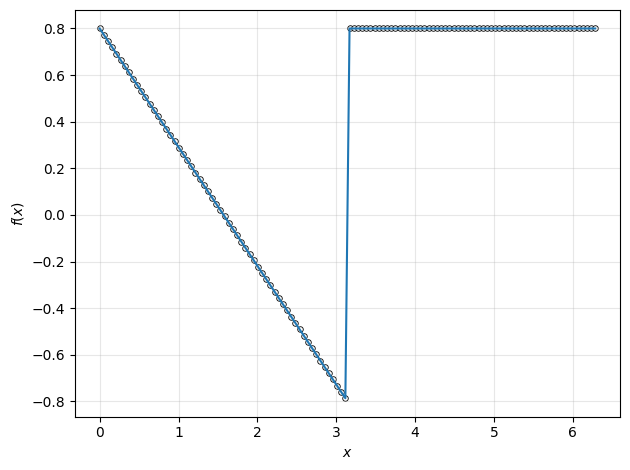

In [13]:
fig, ax = plt.subplots()

ax.plot(x, y_true, linewidth=1.5)
ax.scatter(x, y_true, s=16, facecolors="white", edgecolors="black", linewidths=0.6)

# ax.set_title("Truncated Fourier series of degree 10")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")
ax.grid(True, alpha=0.3)
# ax.legend(frameon=False)

fig.tight_layout()
fig.savefig("saw_square_target_highres.svg", dpi=600, bbox_inches="tight")
# fig.savefig("fourier_degree10_target_highres.pdf",
#             bbox_inches="tight")

plt.show()

In [9]:
coeffs = jnp.array([-0.37241954+0.23431538j, -0.00768933-0.02899783j,
        0.2424051 +0.09402002j, -0.00968506-0.00708517j,
        0.09149331+0.1890211j ,  0.00709596-0.00369423j,
       -0.06186681-0.07209367j, -0.06571778+0.02410754j,
        0.00288075+0.0052632j , -0.15736917-0.0288954j ], dtype=jnp.complex64)
coeffs

Array([-0.37241954+0.23431538j, -0.00768933-0.02899783j,
        0.2424051 +0.09402002j, -0.00968506-0.00708517j,
        0.09149331+0.1890211j ,  0.00709596-0.00369423j,
       -0.06186681-0.07209367j, -0.06571778+0.02410754j,
        0.00288075+0.0052632j , -0.15736917-0.0288954j ], dtype=complex64)